In [ ]:
# install dependencies
!pip install -q sentence-transformers pandas tqdm tiktoken


In [ ]:
#pipeline.py into the VM
from pathlib import Path
pipeline_code = r'''
"""
pipeline.py
High-quality, modular evaluation pipeline for LLM responses.

Features:
- Clean functions with docstrings
- Logging and error handling
- Config dataclass for easy parameter changes
- Batch embedding for speed / memory control
- Hallucination / relevance / completeness detection
- Token estimation (tiktoken if available; fallback heuristic)
- CSV/JSON I/O helpers and summary generation
"""
from dataclasses import dataclass
import json
import logging
import re
from pathlib import Path
from typing import Any, Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer, util

# Configure module-level logger
logger = logging.getLogger("llm_evaluator")
if not logger.handlers:
    handler = logging.StreamHandler()
    formatter = logging.Formatter(
        "%(asctime)s - %(levelname)s - %(message)s", datefmt="%Y-%m-%d %H:%M:%S"
    )
    handler.setFormatter(formatter)
    logger.addHandler(handler)
logger.setLevel(logging.INFO)


@dataclass
class EvalConfig:
    """Configuration for the evaluation pipeline."""
    model_name: str = "all-MiniLM-L6-v2"
    hall_threshold: float = 0.35
    cost_per_1k_tokens_usd: float = 0.002
    batch_size: int = 32  # used for embedding batching
    top_k_keywords: int = 8
    stopwords: Tuple[str, ...] = (
        "the", "and", "is", "in", "to", "of", "a", "for", "on", "with", "that", "this", "it",
        "as", "are", "was", "by", "an", "be", "or"
    )


# Try to use tiktoken for token estimation; fallback if not installed
try:
    import tiktoken  # type: ignore

    _tiktoken_enc = tiktoken.get_encoding("cl100k_base")  # OpenAI-like encoding

    def estimate_tokens(text: str) -> int:
        if not text:
            return 1
        return len(_tiktoken_enc.encode(text))
except Exception:
    def estimate_tokens(text: str) -> int:
        # heuristic: ~0.75 words per token -> tokens ~ words / 0.75
        words = len(str(text).split())
        return max(1, int(words / 0.75))


class LLMEvaluator:
    """Evaluator class wrapping the evaluation logic and model."""

    def __init__(self, cfg: EvalConfig):
        self.cfg = cfg
        logger.info("Loading model: %s", self.cfg.model_name)
        self.model = SentenceTransformer(self.cfg.model_name)

    @staticmethod
    def simple_preprocess(text: Optional[str]) -> str:
        """Basic preprocessing: strip, normalize whitespace, remove nulls."""
        if text is None:
            return ""
        text = str(text).replace("\n", " ").strip()
        text = re.sub(r"\s+", " ", text)
        return text

    @staticmethod
    def split_sentences(text: str) -> List[str]:
        """Split text into sentences using punctuation heuristics."""
        if not text:
            return []
        parts = [s.strip() for s in re.split(r'(?<=[\.\?\!])\s+', text.strip()) if s.strip()]
        return parts

    def extract_top_keywords(self, texts: List[str], top_k: Optional[int] = None) -> List[str]:
        """Extract top tokens (simple frequency-based) excluding stopwords."""
        if top_k is None:
            top_k = self.cfg.top_k_keywords
        stopwords = set(self.cfg.stopwords)
        tokens = []
        for t in texts:
            t_clean = re.sub(r'[^a-zA-Z0-9\s]', ' ', str(t).lower())
            tokens.extend([w for w in t_clean.split() if w and w not in stopwords and len(w) > 2])
        if not tokens:
            return []
        from collections import Counter
        c = Counter(tokens)
        return [w for w, _ in c.most_common(top_k)]

    def _encode_batch(self, texts: List[str]):
        """Encode a list of texts using the SentenceTransformer with batching."""
        if not texts:
            return None
        emb = self.model.encode(texts, batch_size=self.cfg.batch_size, convert_to_tensor=True)
        return emb

    def evaluate(self, conv: Dict[str, Any], ctx: Dict[str, Any]) -> Dict[str, Any]:
        """
        Evaluate single conversation pair.

        Args:
            conv: {"user_message": str, "ai_response": str, "generation": {...}}
            ctx:  {"contexts": [{"text": ...}, ...]}

        Returns:
            result dict with metrics and debug info
        """
        user_msg = self.simple_preprocess(conv.get("user_message", ""))
        ai_resp = self.simple_preprocess(conv.get("ai_response", ""))
        contexts = [c.get("text") if isinstance(c, dict) else str(c) for c in ctx.get("contexts", [])]

        # sentences
        resp_sentences = self.split_sentences(ai_resp)
        # encode contexts and response sentences in batches
        ctx_embs = self._encode_batch(contexts) if contexts else None
        resp_embs = self._encode_batch(resp_sentences) if resp_sentences else None

        # compute sentence-level max similarity to any context chunk
        sims_per_sentence = []
        if resp_embs is not None and ctx_embs is not None and len(resp_embs) > 0 and len(ctx_embs) > 0:
            sims_matrix = util.cos_sim(resp_embs, ctx_embs)  # shape (num_resp_sent, num_ctx)
            sims_per_sentence = [float(sims_matrix[i].max()) for i in range(len(resp_sentences))]
        else:
            sims_per_sentence = [0.0 for _ in resp_sentences]

        # relevance = top sentence similarity (how well response maps to context)
        relevance = max(sims_per_sentence) if sims_per_sentence else 0.0

        # completeness = fraction of top-k keywords from contexts that appear in the response
        keywords = self.extract_top_keywords(contexts)
        matched = [k for k in keywords if k in ai_resp.lower()]
        completeness = len(matched) / max(1, len(keywords)) if keywords else 0.0

        # hallucination: any sentence with max similarity < threshold
        hall_threshold = self.cfg.hall_threshold
        hallucinated = [
            {"sentence": s, "max_similarity": round(sim, 4)}
            for s, sim in zip(resp_sentences, sims_per_sentence)
            if sim < hall_threshold
        ]
        halluc_flag = len(hallucinated) > 0

        # latency from generation metadata if provided
        gen = conv.get("generation", {})
        latency_ms = None
        try:
            if gen.get("start_time") and gen.get("end_time"):
                latency_ms = (float(gen["end_time"]) - float(gen["start_time"])) * 1000.0
        except Exception:
            latency_ms = None

        # token estimation + cost
        tokens = gen.get("tokens") if isinstance(gen.get("tokens"), int) else estimate_tokens(ai_resp)
        cost_usd = (tokens / 1000.0) * self.cfg.cost_per_1k_tokens_usd

        result = {
            "relevance_score": round(float(relevance), 4),
            "completeness_score": round(float(completeness), 4),
            "hallucination_detected": bool(halluc_flag),
            "hallucinated_sentences": hallucinated,
            "latency_ms": latency_ms,
            "estimated_tokens": int(tokens),
            "estimated_cost_usd": round(float(cost_usd), 6),
            "keywords_from_context": keywords,
            "num_context_chunks": len(contexts),
            "num_response_sentences": len(resp_sentences)
        }
        return result

    def batch_evaluate(self, convs: List[Dict[str, Any]], ctxs: List[Dict[str, Any]], max_items: Optional[int] = None) -> List[Dict[str, Any]]:
        """
        Evaluate batches of conversations. Returns list of results with added 'index'.
        """
        n = len(convs)
        if max_items is not None:
            n = min(n, max_items)
        logger.info("Starting batch evaluation for %d items", n)
        results = []
        for i in range(n):
            try:
                res = self.evaluate(convs[i], ctxs[i])
                res["index"] = i
                results.append(res)
                if (i + 1) % 100 == 0:
                    logger.info("Evaluated %d/%d", i + 1, n)
            except Exception as exc:
                logger.exception("Failed evaluating index %d: %s", i, exc)
                results.append({"index": i, "error": str(exc)})
        logger.info("Batch evaluation finished for %d items", n)
        return results


# -------------------------
# Helper I/O utilities
# -------------------------
def load_json(path: str) -> Any:
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(f"File not found: {path}")
    return json.loads(p.read_text(encoding="utf-8"))


def save_json(obj: Any, path: str):
    Path(path).write_text(json.dumps(obj, indent=2, ensure_ascii=False), encoding="utf-8")
    logger.info("Saved JSON to %s", path)


def load_csv_to_conversations(csv_path: str, user_col: str = "question", answer_col: str = "answer") -> Tuple[List[Dict[str, Any]], List[Dict[str, Any]]]:
    """
    Load CSV with conversation rows and convert to conversations + contexts lists.

    Returns:
        conversations: list of {"user_message", "ai_response", "generation": {}}
        contexts: list of {"contexts": [{"text": ...}, ...]}
    """
    df = pd.read_csv(csv_path)
    # Try to drop unnamed index column if exists
    if "Unnamed: 0" in df.columns:
        df = df.drop(columns=["Unnamed: 0"])

    conversations = []
    contexts = []
    for _, row in df.iterrows():
        user_msg = str(row.get(user_col, "")).strip()
        ai_resp = str(row.get(answer_col, "")).strip()
        conversations.append({"user_message": user_msg, "ai_response": ai_resp, "generation": {}})
        contexts.append({"contexts": [{"text": user_msg}, {"text": ai_resp}]})
    logger.info("Loaded %d rows from %s", len(conversations), csv_path)
    return conversations, contexts


def make_summary_csv(results: List[Dict[str, Any]], out_path: str):
    """Save evaluation results to CSV (flattening some fields)."""
    df = pd.DataFrame(results)
    # drop heavy nested fields if present for CSV readability
    if "hallucinated_sentences" in df.columns:
        df["num_hallucinated_sentences"] = df["hallucinated_sentences"].apply(lambda x: len(x) if isinstance(x, list) else 0)
        df = df.drop(columns=["hallucinated_sentences"])
    df.to_csv(out_path, index=False)
    logger.info("Saved summary CSV to %s", out_path)


# Optional small summary
def compute_aggregate_stats(results: List[Dict[str, Any]]) -> Dict[str, Any]:
    """Return overall averages and counts for quick reporting."""
    valid = [r for r in results if "relevance_score" in r]
    if not valid:
        return {}
    avg_relevance = float(np.mean([r["relevance_score"] for r in valid]))
    avg_completeness = float(np.mean([r["completeness_score"] for r in valid]))
    num_hall = int(sum(1 for r in valid if r.get("hallucination_detected")))
    return {
        "total_evaluated": len(valid),
        "avg_relevance": round(avg_relevance, 4),
        "avg_completeness": round(avg_completeness, 4),
        "num_hallucinations": num_hall
    }


# If used as module, provide a configurable entrypoint
def run_from_paths(csv_path: str, out_json: str = "batch_results.json", out_csv: str = "evaluation_summary.csv", cfg: Optional[EvalConfig] = None, max_items: Optional[int] = None):
    if cfg is None:
        cfg = EvalConfig()
    evaluator = LLMEvaluator(cfg)
    convs, ctxs = load_csv_to_conversations(csv_path)
    results = evaluator.batch_evaluate(convs, ctxs, max_items=max_items)
    save_json(results, out_json)
    make_summary_csv(results, out_csv)
    stats = compute_aggregate_stats(results)
    logger.info("Aggregate stats: %s", stats)
    return results, stats


if __name__ == "__main__":
    import argparse

    parser = argparse.ArgumentParser(description="LLM Evaluation Pipeline runner")
    parser.add_argument("--csv", required=True, help="CSV file path with conversations (question/answer).")
    parser.add_argument("--out-json", default="batch_results.json")
    parser.add_argument("--out-csv", default="evaluation_summary.csv")
    parser.add_argument("--max", type=int, default=None, help="Max items to evaluate (useful for testing).")
    args = parser.parse_args()

    run_from_paths(args.csv, out_json=args.out_json, out_csv=args.out_csv, max_items=args.max)
'''
Path("pipeline.py").write_text(pipeline_code, encoding="utf-8")
print("pipeline.py written to disk.")


pipeline.py written to disk.


In [ ]:
# quick check
!ls -l pipeline.py
!sed -n '1,120p' pipeline.py


-rw-r--r-- 1 root root 12138 Dec 12 10:17 pipeline.py

"""
pipeline.py
High-quality, modular evaluation pipeline for LLM responses.

Features:
- Clean functions with docstrings
- Logging and error handling
- Config dataclass for easy parameter changes
- Batch embedding for speed / memory control
- Hallucination / relevance / completeness detection
- Token estimation (tiktoken if available; fallback heuristic)
- CSV/JSON I/O helpers and summary generation
"""
from dataclasses import dataclass
import json
import logging
import re
from pathlib import Path
from typing import Any, Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer, util

# Configure module-level logger
logger = logging.getLogger("llm_evaluator")
if not logger.handlers:
    handler = logging.StreamHandler()
    formatter = logging.Formatter(
        "%(asctime)s - %(levelname)s - %(message)s", datefmt="%Y-%m-%d %H:%M:%S"
    )
    handler.setFormatter(for

In [ ]:
# upload CSV if needed
from google.colab import files
from pathlib import Path

if not Path("Conversation.csv").exists():
    print("Please upload Conversation.csv now (it should have columns: question, answer)")
    uploaded = files.upload()
    for fn in uploaded.keys():
        print("Uploaded:", fn)
else:
    print("Conversation.csv already exists in workspace.")


Conversation.csv already exists in workspace.


In [ ]:
# run evaluation (adjust batch_size or max_items if you want to test subset)
from pipeline import EvalConfig, run_from_paths

# Tweak config for Colab GPU/CPU memory: for 3k rows batch_size 64/128 is fine.
cfg = EvalConfig(model_name="all-MiniLM-L6-v2", hall_threshold=0.35, batch_size=64, top_k_keywords=8)

# If you want to test only 200 rows first, set max_items=200
results, stats = run_from_paths("Conversation.csv", out_json="batch_results.json", out_csv="evaluation_summary.csv", cfg=cfg, max_items=None)

print("Done. Aggregate stats:")
print(stats)


2025-12-12 10:19:24 - INFO - Loading model: all-MiniLM-L6-v2
INFO:llm_evaluator:Loading model: all-MiniLM-L6-v2
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2025-12-12 10:19:31 - INFO - Loaded 3725 rows from Conversation.csv
INFO:llm_evaluator:Loaded 3725 rows from Conversation.csv
2025-12-12 10:19:31 - INFO - Starting batch evaluation for 3725 items
INFO:llm_evaluator:Starting batch evaluation for 3725 items
2025-12-12 10:19:36 - INFO - Evaluated 100/3725
INFO:llm_evaluator:Evaluated 100/3725
2025-12-12 10:19:40 - INFO - Evaluated 200/3725
INFO:llm_evaluator:Evaluated 200/3725
2025-12-12 10:19:44 - INFO - Evaluated 300/3725
INFO:llm_evaluator:Evaluated 300/3725
2025-12-12 10:19:49 - INFO - Evaluated 400/3725
INFO:llm_evaluator:Evaluated 400/3725
2025-12-12 10:19:53 - INFO - Evaluated 500/3725
INFO:llm_evaluator:Evaluated 500/3725
2025-12-12 10:19:58 - INFO - Evaluated 600/3725
INFO:llm_evaluator:Evaluated 600/3725
2025-12-12 10:20:03 - INFO - Evaluated 700/3725
INFO:llm_evaluator:Evaluated 700/3725
2025-12-12 10:20:06 - INFO - Evaluated 800/3725
INFO:llm_evaluator:Evaluated 800/3725
2025-12-12 10:20:10 - INFO - Evaluated 900/3725
INFO:llm

Done. Aggregate stats:
{'total_evaluated': 3725, 'avg_relevance': 0.9782, 'avg_completeness': 0.4861, 'num_hallucinations': 147}


In [ ]:
# Cell 6: download outputs
from google.colab import files
files.download("evaluation_summary.csv")
files.download("batch_results.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

                             count         mean          std       min  \
relevance_score             3725.0     0.978169     0.063414  0.586000   
completeness_score          3725.0     0.486061     0.212363  0.000000   
latency_ms                     0.0          NaN          NaN       NaN   
estimated_tokens            3725.0     8.436779     3.422236  2.000000   
estimated_cost_usd          3725.0     0.000017     0.000007  0.000004   
num_context_chunks          3725.0     2.000000     0.000000  2.000000   
num_response_sentences      3725.0     1.135839     0.355736  1.000000   
index                       3725.0  1862.000000  1075.459204  0.000000   
num_hallucinated_sentences  3725.0     0.040537     0.202614  0.000000   

                                   25%          50%         75%         max  
relevance_score               1.000000     1.000000     1.00000     1.00000  
completeness_score            0.375000     0.500000     0.62500     1.00000  
latency_ms               

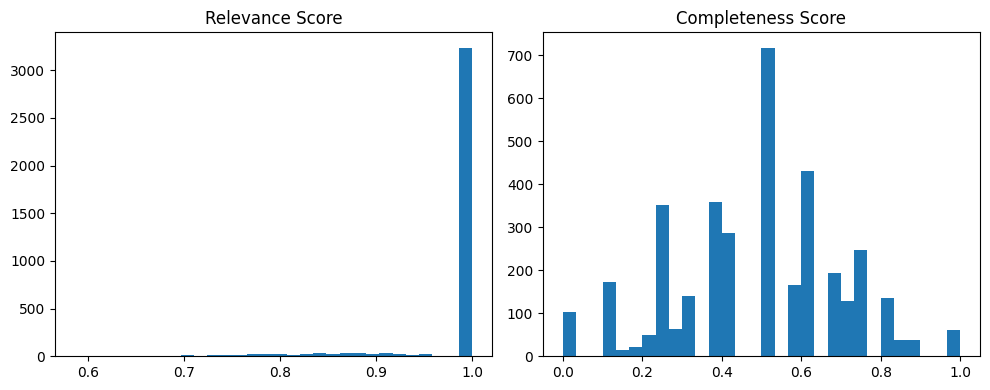

In [ ]:
#  plotting (pandas + matplotlib)
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("evaluation_summary.csv")
print(df.describe().T)

# Histogram of relevance and completeness
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(df['relevance_score'].dropna(), bins=30)
plt.title('Relevance Score')

plt.subplot(1,2,2)
plt.hist(df['completeness_score'].dropna(), bins=30)
plt.title('Completeness Score')
plt.tight_layout()
plt.show()
